In [1]:
# Standard code libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt

# Custom code libraries from the ReSurfEMG
from resurfemg.data_classes.data_classes import TimeSeriesGroup, VentilatorDataGroup

%matplotlib widget

In [14]:
t_duration = 11

# Define EMG signal
fs_emg = 2048
t_emg = np.array([s_t/fs_emg for s_t in range(t_duration*fs_emg)])
y_amps = [2, 5, 12]
y_sin = np.cos((0.5* t_emg - 0.5)* 2 * np.pi)
y_sin[y_sin < 0] = 0
y_emg = np.zeros((3, len(t_emg)))
for idx, y_amp in enumerate(y_amps):
    y_rand = np.random.normal(0, 1, size=len(y_sin))
    y_rand_baseline = np.random.normal(0, 1, size=len(y_sin)) / 10
    y_t = y_amp * y_sin * y_rand + y_rand_baseline
    y_emg[idx, :] = y_t

# Define ventilator
fs_vent = 100
t_vent = np.array([s_t/fs_vent for s_t in range(t_duration*fs_vent)])
y_vent = np.zeros((3, len(t_vent)))
y_sin_rect = np.sin((0.5* t_vent - 0.5)* 2 * np.pi)
y_sin_rect[y_sin_rect < 0] = 0

for idx in range(3):
    match idx:
        case 0:
            y_block = scipy.signal.square(
                (t_vent - 1)/2 * 2 * np.pi, duty=0.5)
            y_block[y_block < 0] = 0
            y_vent[idx, :] = 10 * y_block + 5

            y_vent[idx, t_vent > 6] = -5 * y_sin_rect[t_vent > 6] + 5
        case 1:
            y_sin = np.sin((0.5* t_vent - 0.5)* 2 * np.pi)
            y_vent[idx, :] = y_sin

            y_vent[idx, t_vent > 6] = 0 * y_vent[idx, t_vent > 6]
        case _:
            y_sin = np.sin((0.5* t_vent - 0.5)* 2 * np.pi)
            y_sin[y_sin < 0] = 0
            y_vent[idx, :] = y_sin

            y_vent[idx, t_vent > 6] = 0 * y_vent[idx, t_vent > 6]


In [15]:
# emg_timeseries = TimeSeriesData(y_emg, fs=fs_emg, labels=['ECG', 'EMGdi', 'EMGpara'], units=3*['uV'])
# emg_timeseries.envelope(signal_type='raw')
# emg_timeseries.baseline()

# vent_timeseries = TimeSeriesData(y_vent, fs=fs_vent, labels=['Paw', 'F', 'Vvent'], units=['cmH2O', 'L/s', 'L'])

emg_timeseries = TimeSeriesGroup(y_emg, fs=fs_emg, labels=['ECG', 'EMGdi', 'EMGpara'], units=3*['uV'])
emg_timeseries.envelope(signal_type='raw')
emg_timeseries.baseline()

vent_timeseries = VentilatorDataGroup(y_vent, fs=fs_vent, labels=['Paw', 'F', 'Vvent'], units=['cmH2O', 'L/s', 'L'])
vent_timeseries.baseline(channel_idxs=[0], signal_type='raw')

Text(0.5, 0, 't (s)')

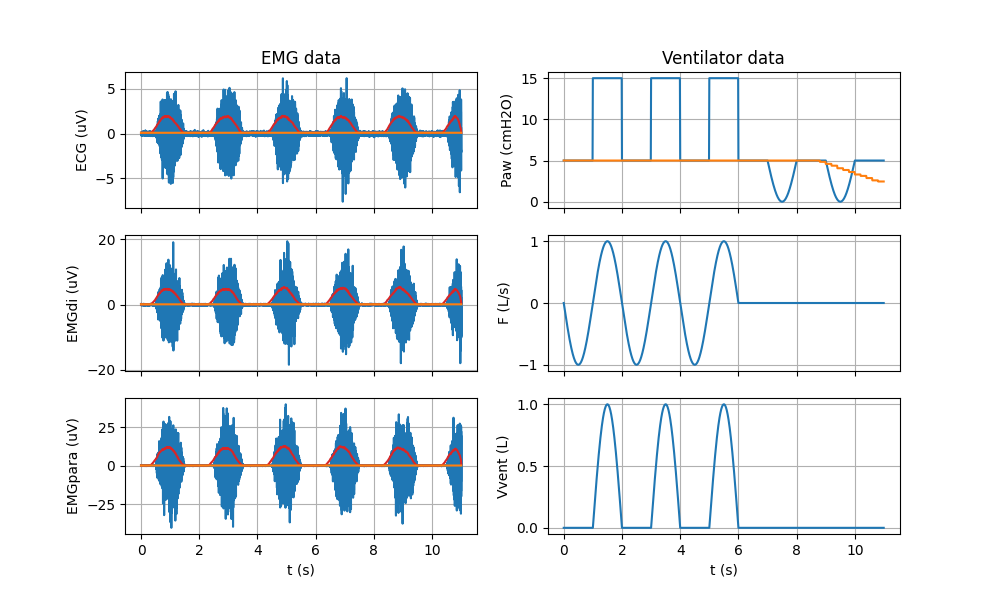

In [16]:
# Plot the raw data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
axes_emg = axis[:, 0]
colors = ['tab:red', 'tab:orange']
emg_timeseries.plot_full(axes_emg, signal_type='raw', baseline_bool=False)
emg_timeseries.plot_full(axes_emg, signal_type='env', colors=colors)
axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

axes_vent = axis[:, 1]
vent_timeseries.plot_full(axes_vent)
axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')

In [17]:
vent_timeseries.peep
vent_timeseries.find_occluded_breaths(vent_timeseries.p_aw_idx)



In [18]:
paw = vent_timeseries.channels[vent_timeseries.p_aw_idx]
paw.peaks['Pocc'].detect_on_offset(baseline=paw.y_baseline)
paw.peaks['Pocc'].starts_s, paw.peaks['Pocc'].ends_s

(array([700, 902]), array([800, 991]))

In [19]:
peaks_s, _ = scipy.signal.find_peaks(
    emg_timeseries.channels[0].y_env, prominence=1.0)


emg_timeseries.channels[0].set_peaks(
    peak_set_name='breaths',
    peaks_s=peaks_s,
    signal=emg_timeseries.channels[0].y_env)

# emg_timeseries.channels[0].peaks['breaths']
emg_timeseries.channels[0].peaks['breaths'].detect_on_offset(
    baseline=emg_timeseries.channels[0].y_baseline
)
emg_di = emg_timeseries.channels[0]

In [20]:
emg_di.peaks['breaths'].starts_s, emg_di.peaks['breaths'].peaks_s, emg_di.peaks['breaths'].ends_s

(array([  650,  4766,  8862, 12964, 17051, 21155]),
 array([ 1872,  6127,  9980, 14065, 18158, 22111], dtype=int64),
 array([ 3011,  7121, 11236, 15327, 19631, 22526]))

In [21]:
breath_data = emg_timeseries.channels[0].peaks['breaths']
breath_data.starts_s/fs_emg, breath_data.peaks_s/fs_emg, breath_data.ends_s/fs_emg, breath_data.valid

(array([ 0.31738281,  2.32714844,  4.32714844,  6.33007812,  8.32568359,
        10.32958984]),
 array([ 0.9140625 ,  2.99169922,  4.87304688,  6.86767578,  8.86621094,
        10.79638672]),
 array([ 1.47021484,  3.47705078,  5.48632812,  7.48388672,  9.58544922,
        10.99902344]),
 [True, True, True, True, True, True])